## Projecting the Growth of Infected Individuals from Confirmed Cases with COVID-19 in the Philippines

by: [Chris Monterola](https://chrismonterola.net) and [Erika Legara](https://erikalegara.site)

### What's this about?
Indeed, this is a new kind of war we are fighting. "New" to our generation, at least -- the **COVID-19 virus**.

It's crazy how in January we were just watching and following the news on how the virus has gripped China. It wasn't until February 2020 when we had the first *confirmed* case in the Philippines.

In this post, we implement an elementary mathematical model that allows us to project the potential growth of confirmed cases.

### Findings

As of this posting, 16 March 2020, we expect that for the Philippines, the number of infected individuals will grow to more than 1,600 in a week's time. And, if the dynamics do not change/improve, it can **reach up to 18,300 the week after that**. 

Why should we be worried? 

We're worried because this number is not something our healthcare system can handle. We have noted that our country has less than 2,000 hospital beds for ICU (critical) patients; and that we have a little less than 90,000 regular hospital beds. Where are we going to place our sick kababayan?

#### The Data and the Math have spoken.
Empirical data show that we have an almost perfect exponential growth (see the figure below plotted in a semi-log scale). To compare across country trends, we set all of today's (16 March 2020) datapoints to Day 20, and make the projection until 30 March 2020.

#### How accurate is this?
Yesterday, Metro Manila was under community quarantine. Today, it was just announced that we're having an "enhanced" community quarantine. Will this be effective? Probably. Hopefully. We'll only really know once we see a change in the trend (i.e., we see a deviation from an exponential growth) in the next week or so.

<img src="Growth of COVID Infected Indviduals.png" width="100%">

## For the technical people

### Data

The dataset was downloaded from the [World Health Organization](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/). 

We did not any more look at the veracity of all WHO collected data, but we did zoom in on the Philippines. We noticed that data on the Philippines had errors; so, these were corrected as well. 

---

Let's begin, and import the needed Python libraries. We also define here our fave color palette.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

tab10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
         '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']

%matplotlib inline

Here's the data.

In [2]:
df = pd.read_csv('full_data.csv')
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2/25/20,Afghanistan,NaN,NaN,1,NaN
1,2/26/20,Afghanistan,0.0,NaN,1,NaN
2,2/27/20,Afghanistan,0.0,NaN,1,NaN


Let's look at the countries.

In [3]:
df.location.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Chile', 'China', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       "Cote d'Ivoire", 'Democratic Republic of Congo', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Gibraltar', 'Greece', 'Guadeloupe', 'Guernsey', 'Guinea',
       'Guyana', 'Vatican', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'International', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 6 columns):
date            2408 non-null object
location        2408 non-null object
new_cases       2272 non-null float64
new_deaths      418 non-null float64
total_cases     2408 non-null int64
total_deaths    455 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 113.0+ KB


In [5]:
df.date = pd.to_datetime(df.date)

Notice as well that there's a couple of `NaN`s in this dataset. Let's fix that.

In [6]:
df = df.fillna(0)
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,0.0,0.0,1,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1,0.0


In this notebook, we're interested in the number and growth of  `total_cases`. 

Now, we're ready to begin.

## Fitting the Model

### Data Exploration

Let's have a peek at our data.

In [7]:
italy = df[(df.location=='Italy') & (df.total_cases >= 100)].total_cases.to_list()
skor = df[(df.location=='South Korea') & (df.total_cases >= 100)].total_cases.to_list()
iran = df[(df.location=='Iran') & (df.total_cases >= 100)].total_cases.to_list()
germany = df[(df.location=='Germany') & (df.total_cases >= 100)].total_cases.to_list()
switzerland = df[(df.location=='Switzerland') & (df.total_cases >= 100)].total_cases.to_list()
usa = df[(df.location=='United States') & (df.total_cases >= 100)].total_cases.to_list()

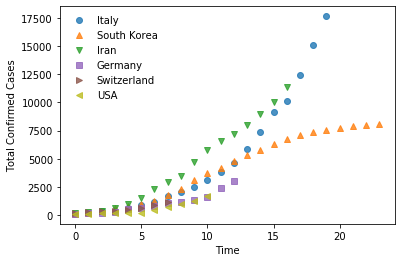

In [8]:
plt.plot(italy, 'o',
         color=tab10[0], alpha = 0.8, label='Italy');
plt.plot(skor, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');
plt.plot(iran, 'v', 
         color=tab10[2], alpha = 0.8, label='Iran');
plt.plot(germany, 's',   
         color=tab10[4], alpha = 0.8, label='Germany');
plt.plot(switzerland, '>', 
         color=tab10[5], alpha = 0.8, label='Switzerland');
plt.plot(usa, '<', 
         color=tab10[8], alpha = 0.8, label='USA');

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

With Italy, Iran, and Germany, the trends look exponential. On the other hand, South Korea looks very much like a logistic curve. Thus, we'll use both in this exploratoin.

Further, to properly compare  trends, we trim the data points such that today will be set to Day 20; in addition, we the first data point will be that when it reaches its first (or equal to) 100 cases. We then make projections until 30 March 2020. 

#### The Philippines
Compared to the other trends above, the Philippines is a little "lagging"; we have, as of this writing, just breached 100 confirmed cases (20 March 2020). And here's the trend.

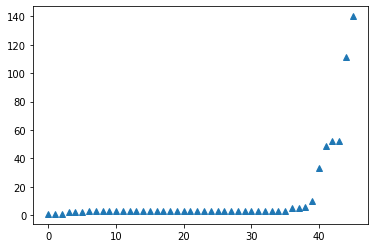

In [9]:
plt.plot(df[(df.location=='Philippines')].total_cases.to_list(), '^', 
         color=tab10[0], label='Philippines');

Looking at the most recent 20 datapoints...

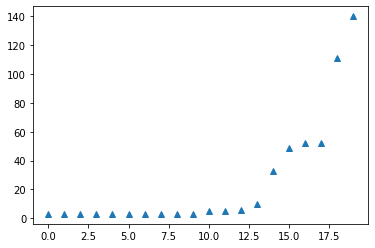

In [10]:
plt.plot(df[(df.location=='Philippines')].total_cases.to_list()[-20:], '^', 
         color=tab10[0], label='Philippines');

### Trend Fitting

In [11]:
def exponential(x,a,b):
    return a * np.exp(b*x)

def logistic(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

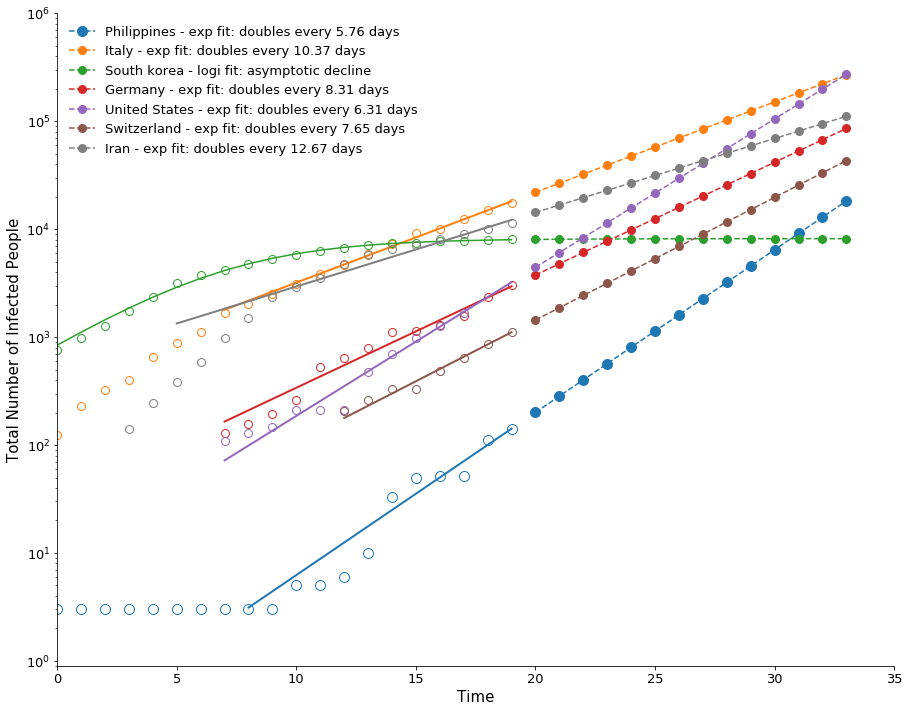

In [12]:
plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 13})

#PHILIPPINES
y = df[(df.location=='Philippines')].total_cases.to_list()
y=y[-20:]
x = np.arange(0, len(y))
popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])

x_fit = np.arange(8, len(y))
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y), len(y)+14)
y_projection=exponential(x_projection, *popt)

rate_RP=(np.exp(tuple(popt)[1]))-1
double_RP= 2/np.log(1+ rate_RP)

plt.semilogy(x,y,'o', ms=10, markerfacecolor='none', color = tab10[0]);
plt.semilogy(x_projection,y_projection,'o--', ms=10, color = tab10[0], 
         label='Philippines - exp fit: doubles every %.2f days' % double_RP)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[0])


#ITALY
y = italy
x = np.arange(0, len(y))

popt, pcov = curve_fit(exponential, x, y, p0 = [0,0])
x_fit = np.arange(7, len(y))
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y), len(y)+14)
y_projection=exponential(x_projection, *popt)

rate_Italy=(np.exp(tuple(popt)[1]))-1
double_Italy= 2/np.log(1+ rate_Italy)

plt.semilogy(x,y,'o', ms=8, markerfacecolor='none', color = tab10[1])
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[1], 
         label='Italy - exp fit: doubles every %.2f days' % double_Italy)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[1]) 


#SOUTH KOREA
y = skor
y=y[-20:]
x = np.arange(0, len(y))

#popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])
popt2, pcov2 = curve_fit(logistic, x, y, p0 = [3.5,50,5000])

x_fit = np.arange(0, 20)
y_exp_fit = exponential(x_fit, *popt)
y_logi_fit = logistic(x_fit, *popt2)

x_projection = np.arange(len(y), len(y)+14)
y_projection=logistic(x_projection, *popt2)

#plt.semilogy(x_fit, y_exp_fit,'--', lw=2, color = tab10[0],
#         label='exp fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[2], label='South korea - logi fit: asymptotic decline')
plt.semilogy(x_fit,y_logi_fit,'-', ms=8, color = tab10[2])
plt.semilogy(x,y,'o', ms=8, markerfacecolor='none', color = tab10[2])

#GERMANY
y = germany
y=y[-20:]
x = np.arange(7, len(y)+7)
popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])
x_fit = np.arange(7, 20)
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y)+7, len(y)+14+7)
y_projection=exponential(x_projection, *popt)

rate_Germany=(np.exp(tuple(popt)[1]))-1
double_Germany= 2/np.log(1+ rate_Germany)

plt.semilogy(x,y,'o', ms=8, markerfacecolor='none',  color = tab10[3])
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[3],label='Germany - exp fit: doubles every %.2f days' % double_Germany)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[3])

# USA
y = usa
x = np.arange(7, len(y)+7)
popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])
x_fit = np.arange(7, 20)
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y)+9, len(y)+14+9)
y_projection=exponential(x_projection, *popt)

rate_USA=(np.exp(tuple(popt)[1]))-1
double_USA= 2/np.log(1+ rate_USA)

plt.semilogy(x,y,'o', ms=8, color = tab10[4],  markerfacecolor='none')
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[4],
             label='United States - exp fit: doubles every %.2f days' % double_USA)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[4])

#SWISS
y = switzerland
y=y[-20:]
x = np.arange(12, len(y)+12)
popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])
x_fit = np.arange(12, 20)
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y)+12, len(y)+14+12)
y_projection=exponential(x_projection, *popt)


rate_Swiss=(np.exp(tuple(popt)[1]))-1
double_Swiss= 2/np.log(1+ rate_Swiss)

plt.semilogy(x,y,'o', ms=8, markerfacecolor='none',  color = tab10[5])
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[5],label='Switzerland - exp fit: doubles every %.2f days' % double_Swiss)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[5])

#IRAN
y = iran
x = np.arange(3, len(y)+3)
popt, pcov = curve_fit(exponential, x, y, p0 = [0, 0])
x_fit = np.arange(5, len(y)+3)
y_exp_fit = exponential(x_fit, *popt)

x_projection = np.arange(len(y)+3, len(y)+14+3)
y_projection=exponential(x_projection, *popt)

rate_Iran=(np.exp(tuple(popt)[1]))-1
double_Iran= 2/np.log(1+ rate_Iran)

plt.semilogy(x,y,'o', ms=8, markerfacecolor='none',  color = tab10[7])
plt.semilogy(x_projection,y_projection,'o--', ms=8, color = tab10[7],
             label='Iran - exp fit: doubles every %.2f days' % double_Iran)
plt.semilogy(x_fit, y_exp_fit,'-', lw=2, color = tab10[7])

plt.legend(frameon=False)
plt.xlim(0, 35)
plt.ylim(0.9, 1000000)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time', size=15);
plt.ylabel('Total Number of Infected People', size=15);
plt.savefig('Growth of COVID Infected Indviduals.png', dpi=150)